## Read the image

uint8
(800, 800, 3)


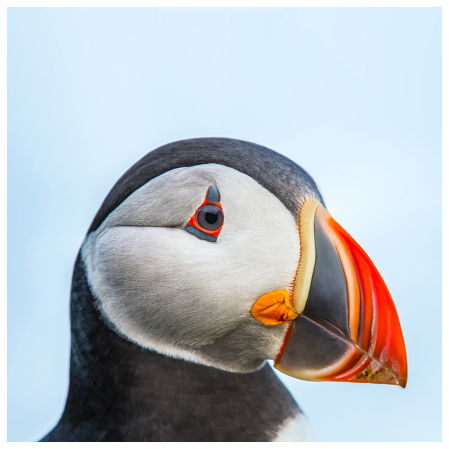

In [116]:
from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np


image = image.imread('source.jpg')

print(image.dtype)
print(image.shape)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


## RGB to YCbCr

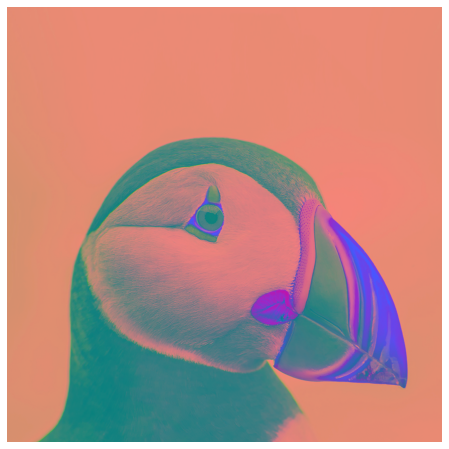

In [117]:
cbcr = np.empty_like(image)

r = image[:, :, 0]
g = image[:, :, 1]
b = image[:, :, 2]

# Y
cbcr[:, :, 0] = .299 * r + .587 * g + .114 * b
# Cb
cbcr[:, :, 1] = 128 - .169 * r - .331 * g + .5 * b
# Cr
cbcr[:, :, 2] = 128 + .5 * r - .419 * g - .081 * b

cbcr = np.uint8(cbcr)

plt.figure(figsize=(8, 8))
plt.imshow(cbcr)
plt.axis('off')
plt.show()


## 3D DCT  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


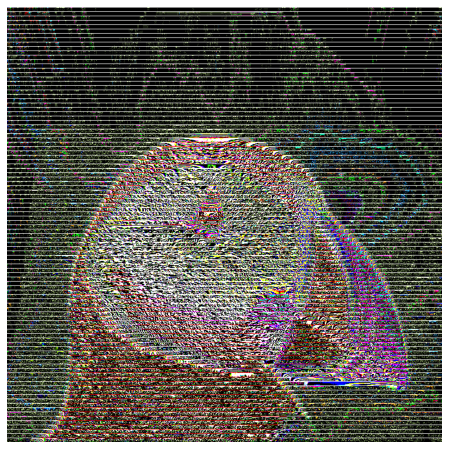

In [118]:
from scipy.fftpack import dct, idct

dct_res = np.zeros(cbcr.shape, dtype=np.float64)

assert cbcr.shape[0] % 8 == 0
assert cbcr.shape[1] % 8 == 0

for i in range(cbcr.shape[0] // 8):
    for j in range(cbcr.shape[1] // 8):
        window = cbcr[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8]
        window = np.array(window)
        dct_res[i * 8: (i + 1) * 8, j * 8: (j + 1) *
                8] = dct(dct(window.T, norm='ortho').T, norm='ortho')

plt.figure(figsize=(8, 8))
plt.imshow(dct_res)
plt.axis('off')
plt.show()


## Quantization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


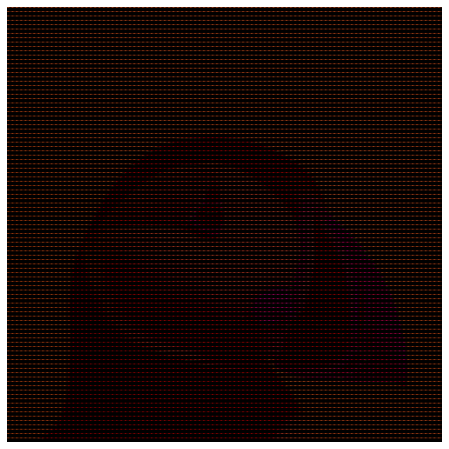

In [119]:
luminance_qt = np.array([[4,  2,  2,  4,  6, 8, 9, 10],
                        [3,  3,  3,  4,  6, 9, 12, 9],
                        [3,  3,  4,  6, 8, 9, 12, 10],
                        [3,  4,  5,  7, 8, 12, 11, 9],
                        [4,  5,  8, 9, 11, 15, 14, 12],
                        [6,  8, 9, 11, 12, 15, 16, 14],
                        [9, 10, 12, 14, 15, 16, 16, 15],
                        [10, 12, 13, 14, 16, 14, 14, 14]])

chrominance_qt = np.array([[4,  4,  6, 8, 9, 10, 11, 12],
                           [4,  5,  6, 9, 11, 11, 12, 12],
                           [6,  6, 10, 11, 12, 12, 12, 12],
                           [8, 9, 10, 11, 12, 12, 12, 12],
                           [10, 11, 11, 12, 12, 12, 12, 12],
                           [11, 11, 12, 12, 12, 12, 12, 12],
                           [12, 12, 12, 12, 12, 12, 12, 12],
                           [12, 12, 12, 12, 12, 12, 12, 12]])


quantize_res = np.zeros(dct_res.shape, dtype=np.int16)

assert dct_res.shape[0] % 8 == 0
assert dct_res.shape[1] % 8 == 0

for i in range(dct_res.shape[0] // 8):
    for j in range(dct_res.shape[1] // 8):
        window = dct_res[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8]

        quantize_res[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8,
                     0] = np.floor(np.divide(np.array(window[:, :, 0]), luminance_qt))
        quantize_res[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8,
                     1] = np.floor(np.divide(np.array(window[:, :, 1]), luminance_qt))
        quantize_res[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8,
                     2] = np.floor(np.divide(np.array(window[:, :, 2]), luminance_qt))


plt.figure(figsize=(8, 8))
plt.imshow(quantize_res, vmin=0, vmax=255)
plt.axis('off')
plt.show()


## Creating Huffman tree

In [120]:
import heapq
import collections.abc


class PriorityQueue:
    """
      Implements a priority queue data structure. Each inserted item
      has a priority associated with it and the client is usually interested
      in quick retrieval of the lowest-priority item in the queue. This
      data structure allows O(1) access to the lowest-priority item.
    """

    def __init__(self):
        self.heap = []
        self.count = 0
        self.table = {}
        self.decoded_array = []

    def set_heap(self, new_array):
        self.heap = new_array
        self.count = len(new_array)
        heapq.heapify(self.heap)

    def build_huffman(self):
        while len(self.heap) > 1:
            p0, _, item0 = heapq.heappop(self.heap)
            p1, _, item1 = heapq.heappop(self.heap)
            p = p0 + p1
            item = [item0, item1]
            heapq.heappush(self.heap, (p, self.count, item))
            self.count += 1

    def get_table(self):
        stack = [(self.heap[0][2], "")]

        while stack:
            item, string = stack.pop()
            if not isinstance(item, collections.abc.Sequence):
                self.table[item] = string
            else:
                if len(item) != 2:
                    print(len(item))
                    print("error in tree")
                    return
                stack.append((item[0], string + "0"))
                stack.append((item[1], string + "1"))
        
        return self.table
        
    def decode(self, string):
        item = self.heap[0][2]
        for c in string:
            if not isinstance(item, collections.abc.Sequence):
                self.decoded_array.append(item)
                item = self.heap[0][2]
            if c == "0":
                item = item[0]
            elif c == "1":
                item = item[1]
            else:
                print("error while decoding")
        if not isinstance(item, collections.abc.Sequence):
            self.decoded_array.append(item)
        return self.decoded_array


### Encode Huffman tree

In [121]:
freq_table = {}
for c in quantize_res.ravel():
    if c not in freq_table:
        freq_table[c] = 0
    freq_table[c] += 1

image_entries = list(
    map(lambda x, y: (x[1], y, x[0]), list(freq_table.items()), list(range(len(freq_table)))))

pq = PriorityQueue()
pq.set_heap(image_entries)
pq.build_huffman()
table = pq.get_table()
result = ""
for item in quantize_res.ravel():
    result += table[item]

print(len(result))


5432768


### Decode Huffman tree

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


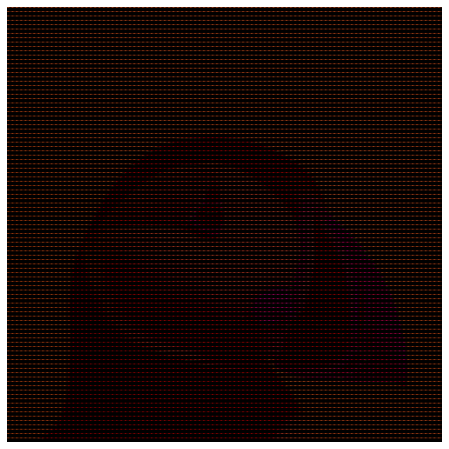

In [122]:
decoded = pq.decode(result)
decoded = np.array(decoded).reshape(image.shape)

plt.figure(figsize=(8, 8))
plt.imshow(decoded, vmin=0, vmax=255)
plt.axis('off')
plt.show()


## Dequantization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


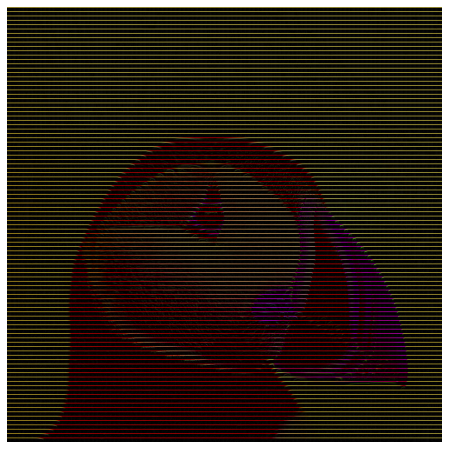

In [123]:
dequantize_res = np.zeros(decoded.shape, dtype=np.int16)

assert decoded.shape[0] % 8 == 0
assert decoded.shape[1] % 8 == 0

for i in range(decoded.shape[0] // 8):
    for j in range(decoded.shape[1] // 8):
        window = decoded[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8]
        
        dequantize_res[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8, 0] = np.multiply(np.array(window[:,:,0]) + 0.5, luminance_qt)
        dequantize_res[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8, 1] = np.multiply(np.array(window[:,:,1]) + 0.5, luminance_qt)
        dequantize_res[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8, 2] = np.multiply(np.array(window[:,:,2]) + 0.5, luminance_qt)

plt.figure(figsize=(8, 8))
plt.imshow(dequantize_res)
plt.axis('off')
plt.show()


## 3D IDCT

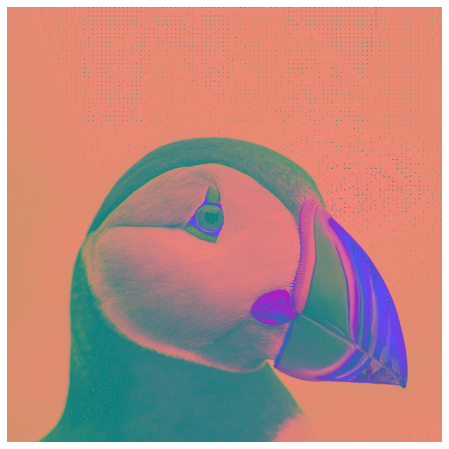

In [139]:
idct_result = np.zeros(dequantize_res.shape, dtype=np.float64)

assert dequantize_res.shape[0] % 8 == 0
assert dequantize_res.shape[1] % 8 == 0

for i in range(dequantize_res.shape[0] // 8):
    for j in range(dequantize_res.shape[1] // 8):
        block = dequantize_res[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8]
        window = np.array(block)
        idct_result[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8] = idct(idct(window.T, norm = 'ortho').T, norm = 'ortho')

plt.figure(figsize=(8, 8))
plt.imshow(np.uint8(idct_result),vmin = 0,vmax = 255)
plt.axis('off')
plt.show()

## YCbCr to RGB and final result

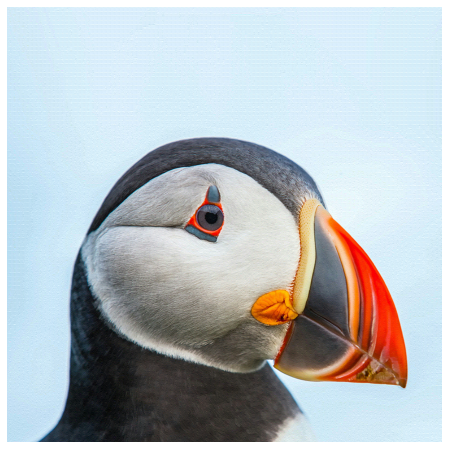

In [138]:
xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])

rgb = idct_result.astype(np.float64)

rgb[:,:,[1,2]] -= 128
rgb = rgb.dot(xform.T)

np.putmask(rgb, rgb > 255, 255)
np.putmask(rgb, rgb < 0, 0)   

rgb = rgb.astype('uint8')

plt.figure(figsize=(8, 8))
plt.imshow(rgb, vmin=0, vmax=255)
plt.axis('off')
plt.imsave('Huffman_compressed.png',rgb, vmin = 0, vmax= 255)
plt.show()